Setting the Scene


Imagine you are working for a social media company. The company is concerned with the growing amount of fake news circulatng on it's platform. They have assigned you to investigate how fake news can be recognized and create a method of identifying it. Let's work through this problem together, first by exploring and cleaning the data and then working to classify fake vs factual news stories. We'll also create some plots of our outputs and discuss how we would communicate our findings to stakeholders.



In [412]:
import pandas as pd
import matplotlib.pyplot as plt

In [413]:
# Set plot options
plt.rcParams['figure.figsize'] = (12, 8)
default_plot_colour = "#00bfbf"

In [414]:
data = pd.read_csv("fake_news_data.csv")
data.head(10)

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News
5,Maxine Waters Makes Teens Chant ‘Impeach 45′ a...,Shame on Teen Vogue! Maxine Waters was a guest...,"Dec 10, 2017",Fake News
6,Jay Carney Let It Slip That He Knows Who Obam...,Former White House Press Secretary in the Obam...,"February 10, 2016",Fake News
7,"Trump threat fires up U.S. climate activists, ...",(Reuters) - Seattle financial worker Harrison ...,"November 11, 2016",Factual News
8,Stephen King Is BRUTALLY Making Fun Of Trump ...,With Donald Trump s intensely bizarre and craz...,"March 4, 2017",Fake News
9,China labels Trump call 'petty action' by Taiw...,BEIJING (Reuters) - U.S. President-elect Donal...,"December 3, 2016",Factual News


Text(0.5, 0, 'Classification')

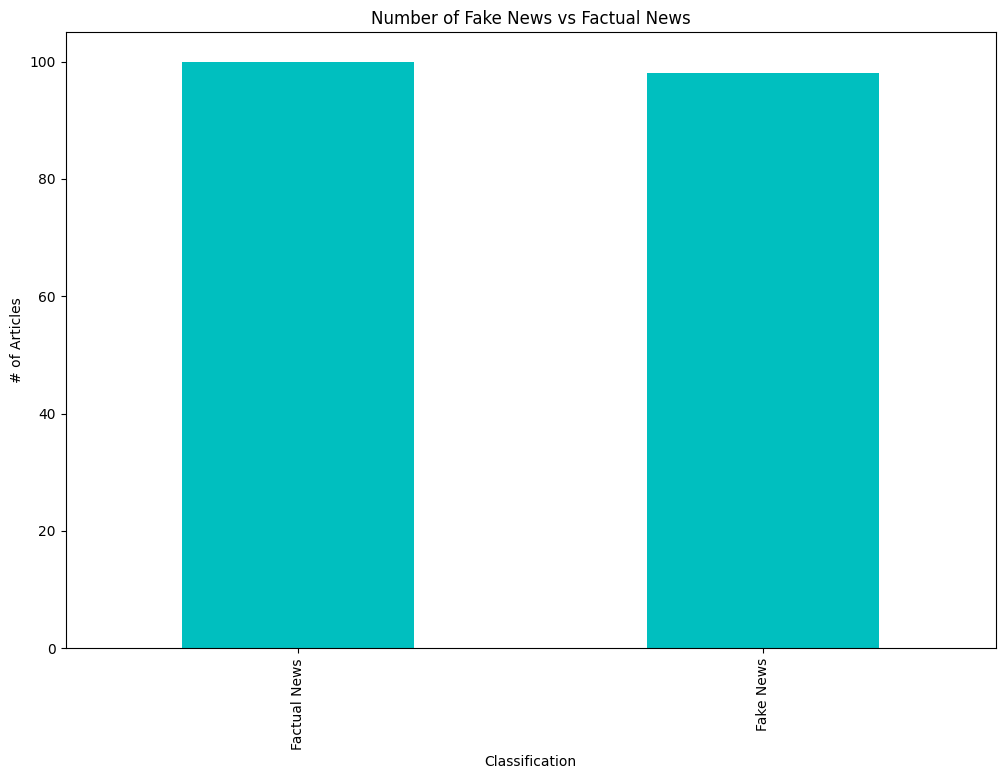

In [415]:
# Plot the number of fake news and factual news
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_colour)
plt.title('Number of Fake News vs Factual News')
plt.ylabel('# of Articles')
plt.xlabel('Classification')

In [416]:
import seaborn as sns
import spacy
from spacy import displacy, tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel, LdaModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

POS Tagging

In [417]:
nlp = spacy.load("en_core_web_sm")

In [418]:
# Split the data into fake and factual news
fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']


In [419]:
# Create spacey documents - use pipe for dataframe
fake_spaceydocs = list(nlp.pipe(fake_news['text']))
fact_spaceydocs = list(nlp.pipe(fact_news['text']))

In [420]:
# Create a function to extract tags for each document in our data
def extract_token_tags(doc: spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [421]:
# Tag fake dataset
fake_tagsdf = []
columns = ['token', 'ner_tag', 'pos_tag']

for ix, doc in enumerate(fake_spaceydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)
    
fake_tagsdf = pd.concat(fake_tagsdf)

# tag factual dataset
fact_tagsdf = []
columns = ['token', 'ner_tag', 'pos_tag']

for ix, doc in enumerate(fact_spaceydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)
    
fact_tagsdf = pd.concat(fact_tagsdf)

In [422]:
fake_tagsdf.head(10)

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN
5,with,,ADP
6,your,,PRON
7,analogy,,NOUN
8,Susan,PERSON,PROPN
9,,PERSON,SPACE


In [423]:
# token frequency count (fake)
pos_counts_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(
    name='counts').sort_values(by='counts', ascending=False)

pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [424]:
# token frequency count (fact)
pos_counts_fact = fact_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(
    name='counts').sort_values(by='counts', ascending=False)

pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [425]:
# Frequencies of POS tags (fake)
pos_counts_fake.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

In [426]:
# Frequencies of POS tags (fact)
pos_counts_fact.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

In [427]:
# Diferences in nouns (fake)
pos_counts_fake[pos_counts_fake.pos_tag == 'NOUN'][0:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [428]:
# Differences in nouns (fact)
pos_counts_fact[pos_counts_fact.pos_tag == 'NOUN'][0:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


NER TAGGING

In [429]:
# Top entities in fake news
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ''].groupby(
    ['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

top_entities_fake.head(10)

,token,ner_tag,counts
1730,Trump,PERSON,154
1729,Trump,ORG,152
2129,the,ORG,121
592,Clinton,PERSON,118
718,Donald,PERSON,75
890,Hillary,PERSON,64
1329,Obama,PERSON,59
1179,McCain,PERSON,53
2167,year,DATE,44
1662,Syria,GPE,42


In [430]:
# Top entities in fact news
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ''].groupby(
    ['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

top_entities_fact.head(10)

,token,ner_tag,counts
1968,the,ORG,159
1633,U.S.,GPE,138
1373,Reuters,ORG,131
1615,Trump,PERSON,125
1614,Trump,ORG,124
882,House,ORG,67
1997,year,DATE,63
1646,United,GPE,59
1965,the,GPE,59
1254,Obama,PERSON,55


[Text(0.5, 1.0, 'Top 10 Entities in Fake News')]

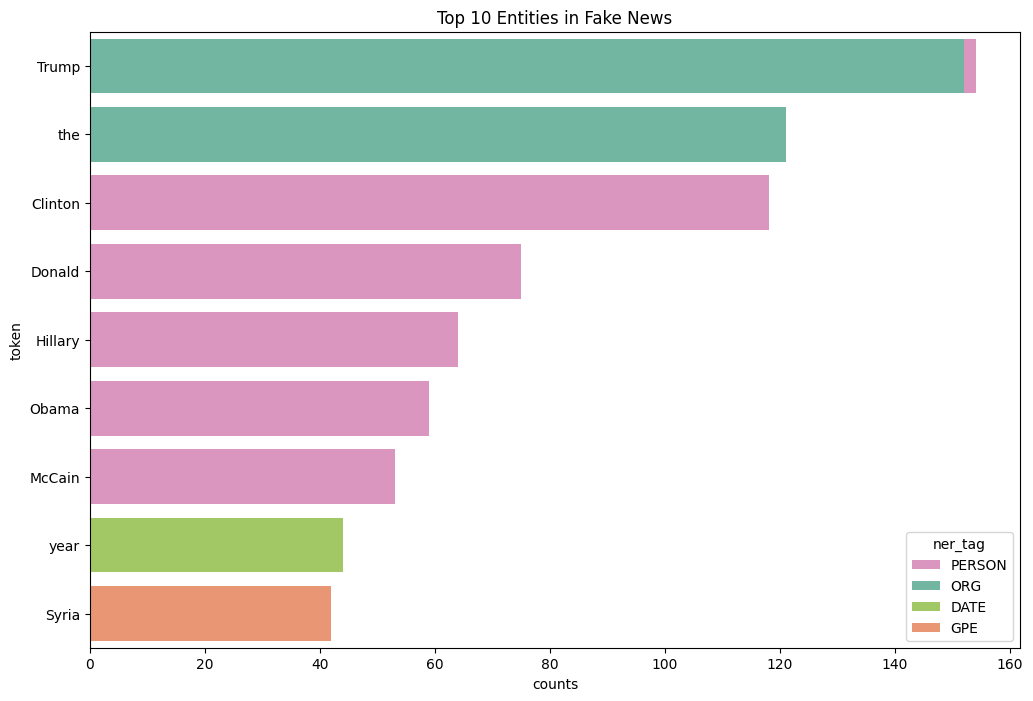

In [431]:
# Create custom palette to ensure plots are consistent
new_palette = {
    'ORG': sns.color_palette('Set2').as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

sns.barplot(
    x='counts',
    y='token',
    hue='ner_tag',
    palette=new_palette,
    data=top_entities_fake[0:10],
    orient='h',
    dodge=False
).set(title='Top 10 Entities in Fake News')

[Text(0.5, 1.0, 'Top 10 Entities in Factual News')]

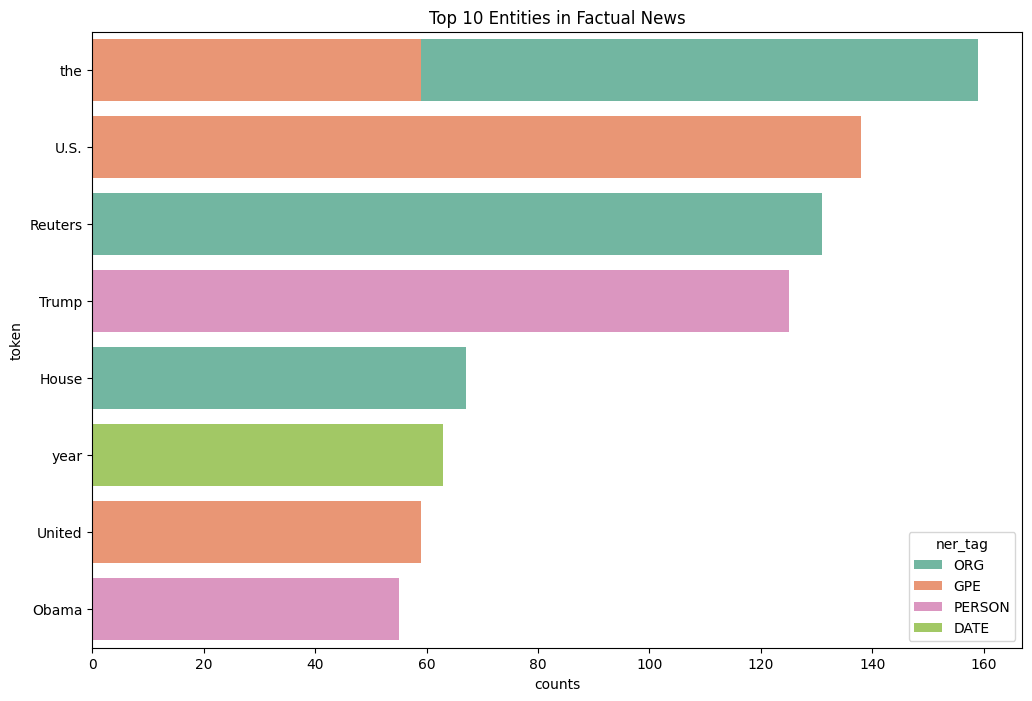

In [432]:
sns.barplot(
    x='counts',
    y='token',
    hue='ner_tag',
    palette=new_palette,
    data=top_entities_fact[0:10],
    orient='h',
    dodge=False
).set(title='Top 10 Entities in Factual News')

TEXT PRE-PROCESSING

In [433]:
# A lot of the factual news have a location tag at the beginning of the article, let's use regex to remove this
data['text_clean'] = data.apply(
    lambda x: re.sub(r'^[^-]*-\s*', '', x['text']), axis=1)

In [434]:
# Lowercase
data['text_clean'] = data['text_clean'].str.lower()

In [435]:
# Remove punctuation
data['text_clean'] = data.apply(
    lambda x: re.sub(r'([^\w\s])', '', x['text_clean']), axis=1)

In [436]:
# Load stopwords
en_stopwords = stopwords.words('english')

# Remove stopwords
data['text_clean'] = data['text_clean'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in en_stopwords]))

In [437]:
# Tokenize
data['text_clean'] = data.apply(
    lambda x: word_tokenize(x['text_clean']), axis=1)

In [438]:
# Lemmatize
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(
    lambda x: [lemmatizer.lemmatize(word) for word in x])

In [439]:
data.head(10)

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."
5,Maxine Waters Makes Teens Chant ‘Impeach 45′ a...,Shame on Teen Vogue! Maxine Waters was a guest...,"Dec 10, 2017",Fake News,"[58, resolution, consider, move, week, fox, ne..."
6,Jay Carney Let It Slip That He Knows Who Obam...,Former White House Press Secretary in the Obam...,"February 10, 2016",Fake News,"[inneck, race, must, pretty, antsy, though, un..."
7,"Trump threat fires up U.S. climate activists, ...",(Reuters) - Seattle financial worker Harrison ...,"November 11, 2016",Factual News,"[seattle, financial, worker, harrison, karlewi..."
8,Stephen King Is BRUTALLY Making Fun Of Trump ...,With Donald Trump s intensely bizarre and craz...,"March 4, 2017",Fake News,"[donald, trump, intensely, bizarre, crazy, twe..."
9,China labels Trump call 'petty action' by Taiw...,BEIJING (Reuters) - U.S. President-elect Donal...,"December 3, 2016",Factual News,"[u, presidentelect, donald, trump, call, taiwa..."


In [440]:
# Most common unigrams after preprocessing
tokens_clean = sum(data['text_clean'], [])
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)
                      ).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    560
1       (trump,)    520
2           (u,)    255
3       (state,)    250
4   (president,)    226
5       (would,)    210
6         (one,)    141
7        (year,)    128
8  (republican,)    128
9        (also,)    124


/var/folders/cg/8s4d392543z4jdl90crq59nr0000gn/T/ipykernel_46521/2576881245.py:5: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

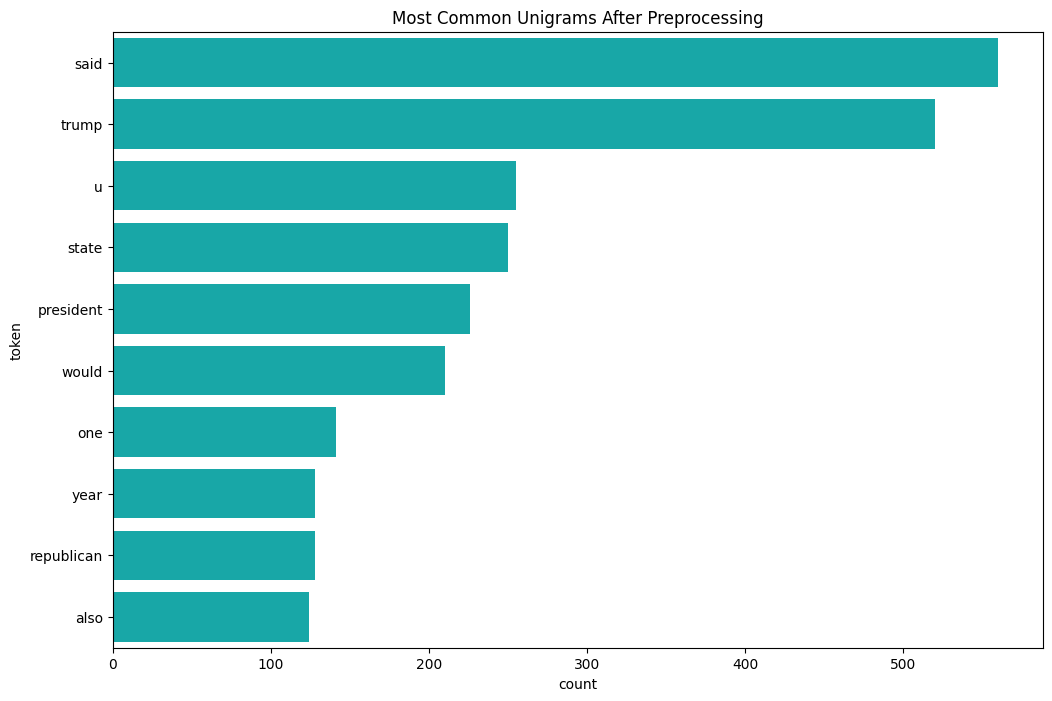

In [441]:
# Plot the most common unigrams
unigrams['token'] = unigrams['index'].apply(
    lambda x: x[0])  # extract the token from the tuple

sns.barplot(
    x='count',
    y='token',
    data=unigrams,
    orient='h',
    palette=[default_plot_colour],
    hue='token',
    legend=False
).set(title='Most Common Unigrams After Preprocessing')

In [442]:
# Most common biagrms after Preprocessing
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts())
print(bigrams)

(donald, trump)            92
(united, state)            80
(white, house)             72
(president, donald)        42
(hillary, clinton)         31
                           ..
(leak, part)                1
(cia, leak)                 1
(latest, cia)               1
(investigation, latest)     1
(campus, reform)            1
Name: count, Length: 33615, dtype: int64


SENTIMENT ANALYSIS

<Axes: xlabel='vader_sentiment_label'>

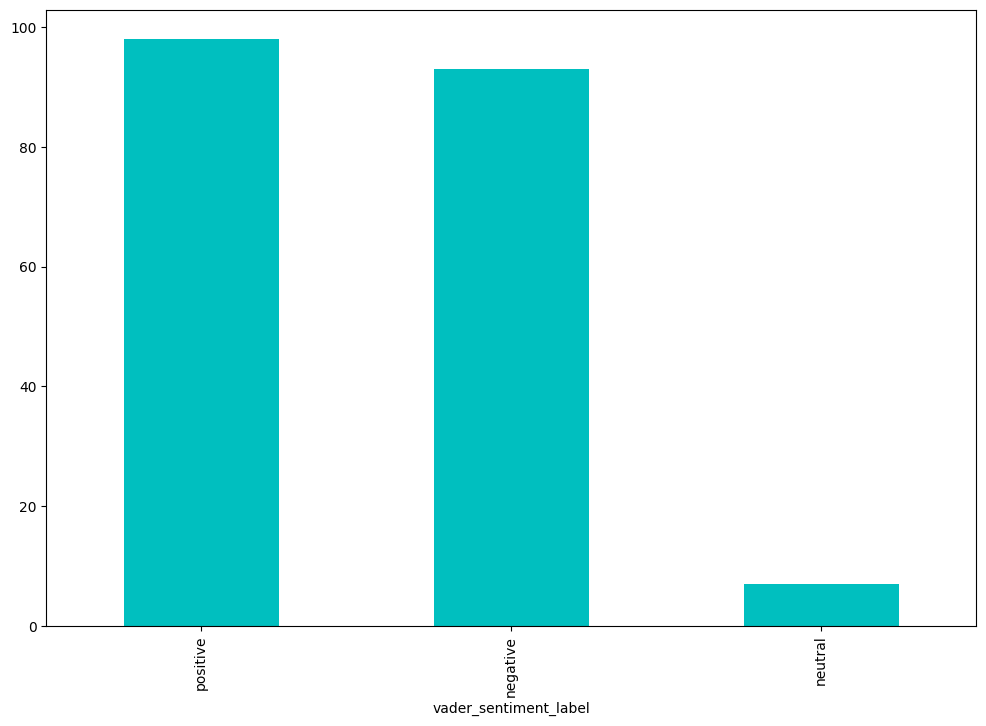

In [443]:
# Use Vader so we also get a neutral sentiment score
vader_sentiment = SentimentIntensityAnalyzer()

data['vader_sentiment_score'] = data['text'].apply(
    lambda review: vader_sentiment.polarity_scores(review)['compound'])

# Create Labels
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

data['vader_sentiment_label'] = pd.cut(
    data['vader_sentiment_score'], bins, labels=names)

data['vader_sentiment_label'].value_counts().plot(
    kind='bar', color=default_plot_colour)

/var/folders/cg/8s4d392543z4jdl90crq59nr0000gn/T/ipykernel_46521/278792921.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

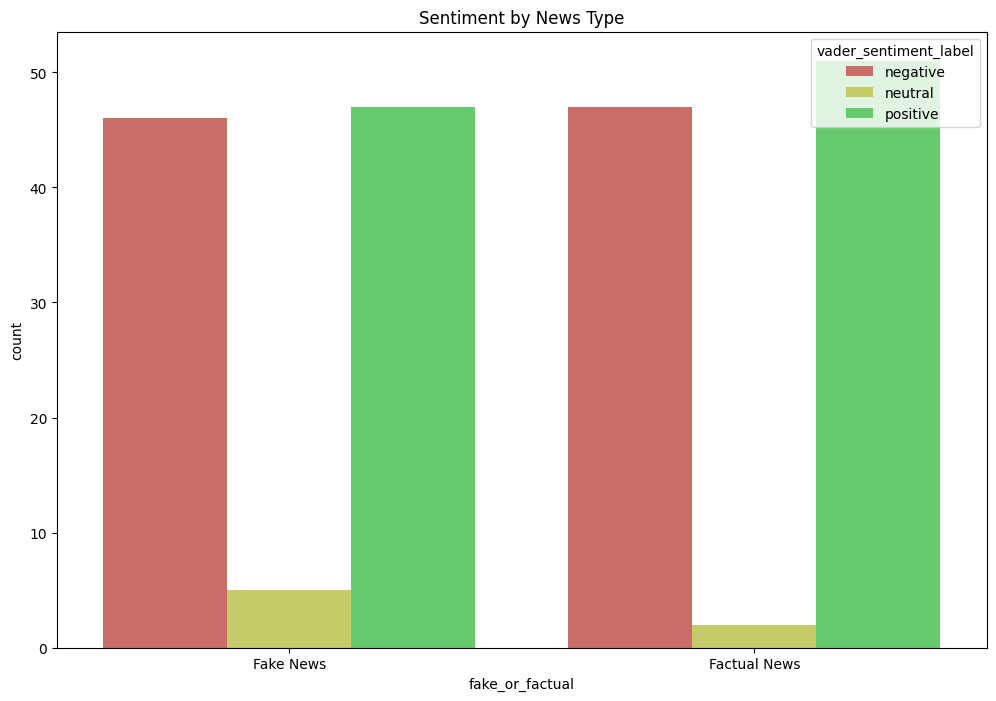

In [444]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    data = data,
    palette=sns.color_palette('hls')
).set(title='Sentiment by News Type')

LDA

In [445]:
# fake news data vectorization
fake_news_text = data[data['fake_or_factual'] ==
                      'Fake News']['text_clean'].reset_index(drop=True)
dictionary_fake = corpora.Dictionary(fake_news_text)
doc_term_fake = [dictionary_fake.doc2bow(doc) for doc in fake_news_text]

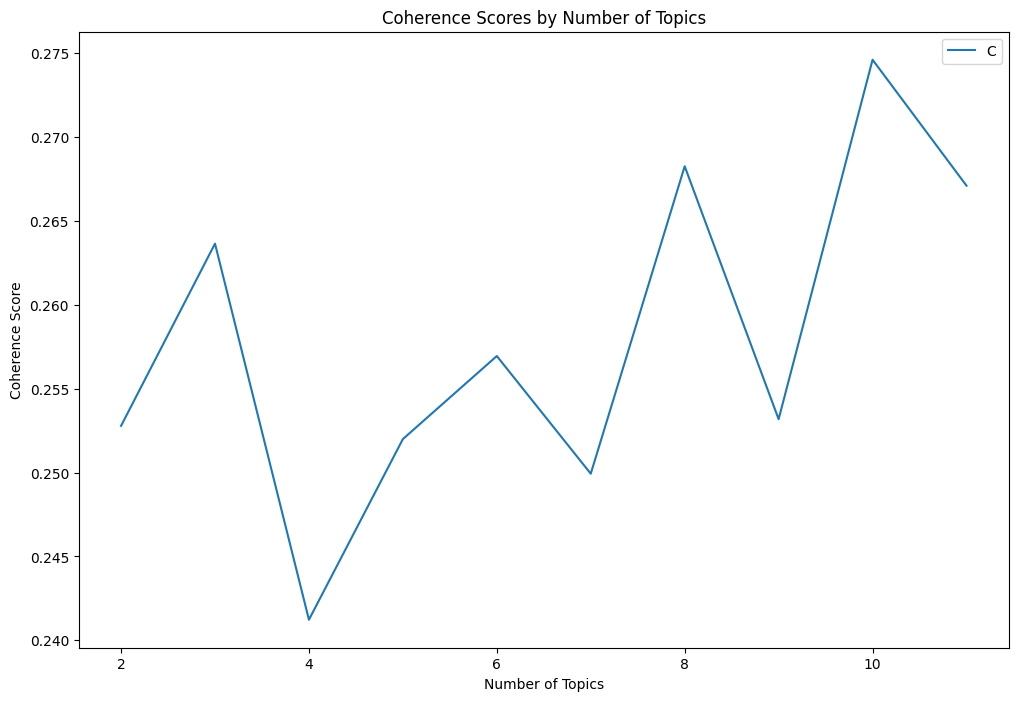

In [446]:
# Generate coherence scores to determin an optimum number of topics
coherence_values = []
model_list = []
min_topics = 2
max_topics = 11

for num_topics in range(min_topics, max_topics+1):
    model = LdaModel(corpus=doc_term_fake, num_topics=num_topics,
                     id2word=dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text,
                                     dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores by Number of Topics")
plt.legend(("Coherence Score"), loc='best')
plt.show()

In [447]:
# Create LDA Model
num_topics_fake = 5
lda_model_fake = LdaModel(corpus=doc_term_fake, num_topics=num_topics_fake,
                          id2word=dictionary_fake)

lda_model_fake.print_topics(num_topics=num_topics_fake, num_words=10)

[(0,
  '0.007*"trump" + 0.005*"republican" + 0.005*"state" + 0.004*"one" + 0.004*"clinton" + 0.004*"would" + 0.003*"said" + 0.003*"president" + 0.003*"people" + 0.003*"year"'),
 (1,
  '0.022*"trump" + 0.005*"president" + 0.004*"time" + 0.004*"said" + 0.004*"donald" + 0.003*"clinton" + 0.003*"woman" + 0.003*"republican" + 0.003*"also" + 0.003*"would"'),
 (2,
  '0.005*"u" + 0.005*"trump" + 0.004*"obama" + 0.004*"said" + 0.004*"state" + 0.004*"mccain" + 0.004*"clinton" + 0.003*"one" + 0.003*"year" + 0.003*"people"'),
 (3,
  '0.008*"trump" + 0.007*"said" + 0.005*"would" + 0.004*"clinton" + 0.004*"state" + 0.004*"u" + 0.004*"woman" + 0.004*"american" + 0.004*"president" + 0.003*"one"'),
 (4,
  '0.010*"trump" + 0.004*"clinton" + 0.004*"said" + 0.004*"would" + 0.004*"time" + 0.003*"president" + 0.003*"one" + 0.003*"u" + 0.003*"state" + 0.003*"people"')]

our topics contain a lot of very similar words, let's try using latent semantic analysis with tf-idf vectorization

TF-IDF & LSA

In [448]:
def tfidf_corpus(doc_term_matrix):
    # create a corpus using tf-idf vectorization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [449]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    # Generate coherence scores to determin an optimum number of topics
    coherence_values = []
    model_list = []

    for num_topics in range(min_topics, max_topics+1):
        model = LsiModel(corpus=corpus, num_topics=num_topics,
                         id2word=dictionary, random_seed=0)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text,
                                         dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    # plot graph
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores by Number of Topics")
    plt.legend(("Coherence Score"), loc='best')
    plt.show()

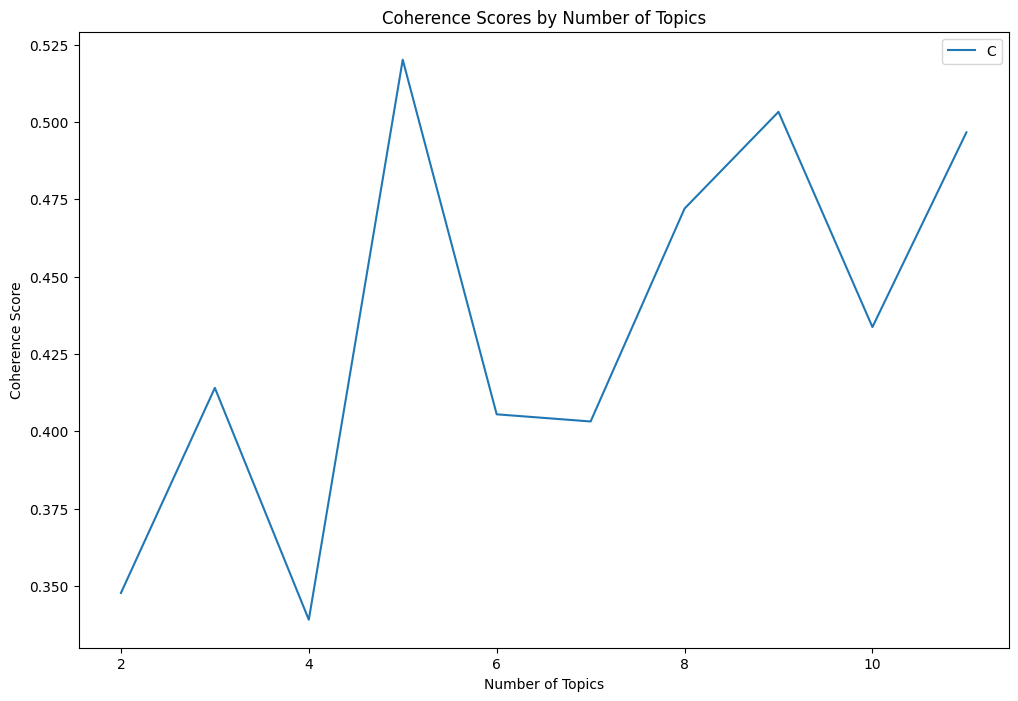

In [450]:
# create tf-idf representation
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

# Coherence scores for fake news data
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text,
                     min_topics=2, max_topics=11)

In [451]:
# model for fake news data
lsa_fake = LsiModel(corpus=corpus_tfidf_fake,
                    id2word=dictionary_fake, num_topics=5)
lsa_fake.print_topics()

[(0,
  '0.218*"trump" + 0.135*"clinton" + 0.094*"woman" + 0.087*"president" + 0.086*"republican" + 0.085*"obama" + 0.084*"party" + 0.083*"school" + 0.081*"said" + 0.079*"time"'),
 (1,
  '0.299*"boiler" + 0.253*"room" + 0.250*"acr" + 0.186*"jay" + 0.185*"animal" + 0.176*"episode" + 0.147*"analysis" + 0.122*"dyer" + 0.119*"savant" + 0.119*"moralist"'),
 (2,
  '-0.219*"school" + 0.195*"clinton" + 0.163*"conference" + -0.151*"county" + -0.137*"student" + 0.120*"press" + 0.116*"trump" + 0.112*"hillary" + -0.101*"love" + 0.095*"email"'),
 (3,
  '0.375*"flynn" + 0.151*"russian" + 0.111*"email" + 0.109*"30" + 0.101*"department" + 0.100*"information" + 0.100*"nana" + 0.099*"official" + 0.098*"mccain" + -0.096*"trump"'),
 (4,
  '-0.235*"trump" + -0.223*"flynn" + -0.166*"conference" + 0.165*"clinton" + 0.153*"dnc" + 0.151*"sander" + 0.127*"email" + -0.111*"press" + 0.109*"rich" + -0.084*"tax"')]

PREDICT FAKE OR FACTUAL NEWS

In [452]:
data.head(10)

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive
5,Maxine Waters Makes Teens Chant ‘Impeach 45′ a...,Shame on Teen Vogue! Maxine Waters was a guest...,"Dec 10, 2017",Fake News,"[58, resolution, consider, move, week, fox, ne...",-0.6781,negative
6,Jay Carney Let It Slip That He Knows Who Obam...,Former White House Press Secretary in the Obam...,"February 10, 2016",Fake News,"[inneck, race, must, pretty, antsy, though, un...",0.9970,positive
7,"Trump threat fires up U.S. climate activists, ...",(Reuters) - Seattle financial worker Harrison ...,"November 11, 2016",Factual News,"[seattle, financial, worker, harrison, karlewi...",0.9937,positive
8,Stephen King Is BRUTALLY Making Fun Of Trump ...,With Donald Trump s intensely bizarre and craz...,"March 4, 2017",Fake News,"[donald, trump, intensely, bizarre, crazy, twe...",-0.9726,negative
9,China labels Trump call 'petty action' by Taiw...,BEIJING (Reuters) - U.S. President-elect Donal...,"December 3, 2016",Factual News,"[u, presidentelect, donald, trump, call, taiwa...",0.4951,positive


In [453]:
X = [','.join(map(str, l)) for l in data['text_clean']]
Y = data['fake_or_factual']

In [454]:
# Text vectorization - CountVectorizer
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(),
                            columns=countvec.get_feature_names_out())

In [455]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    bag_of_words, Y, test_size=0.3
)

In [456]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

accuracy_score(y_pred_lr, y_test)

0.9

In [457]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.84      0.96      0.90        28
   Fake News       0.96      0.84      0.90        32

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.91      0.90      0.90        60



In [458]:
svm = SGDClassifier().fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

accuracy_score(y_pred_svm, y_test)

0.9166666666666666

In [459]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.93      0.89      0.91        28
   Fake News       0.91      0.94      0.92        32

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60

